In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt
import time
import math
import pickle

In [3]:
filename_Xtrain = '../data/X_train.csv'
filename_ytrain = '../data/y_train.csv'
filename_Xtest = '../data/X_test.csv'
filename_ytest = '../data/y_test.csv'

# Set Pandas to show all the columns
pd.set_option('display.max_columns', None)

# Read the data as a dataframe
X_train = pd.read_csv(filename_Xtrain)
y_train = pd.read_csv(filename_ytrain)

X_test = pd.read_csv(filename_Xtest)
y_test = pd.read_csv(filename_ytest)

In [4]:
y_train = y_train.iloc[:,0]
y_test = y_test.iloc[:,0]

### Decision of parameters

As in the LinearSVC we will study which C value fits best with our data with the Grid Search Cross Validation

In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,roc_curve,roc_auc_score
from sklearn.metrics import confusion_matrix,classification_report,plot_confusion_matrix

In [6]:
from sklearn.linear_model import LogisticRegression

In [7]:
startTime = time.time()

Crange = np.logspace(-3,3,7)
param_grid={"C":Crange}

grid=GridSearchCV(LogisticRegression(max_iter = 10000),
                       param_grid = param_grid,cv=10, verbose = 1)
grid.fit(X_train,y_train)

endTime = time.time()
print(f"time of training: {(endTime - startTime)/60} minutes")

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:  3.9min finished


time of training: 3.9269022663434345 minutes
best mean cross-validation score: 0.609
best parameters: {'C': 0.1}


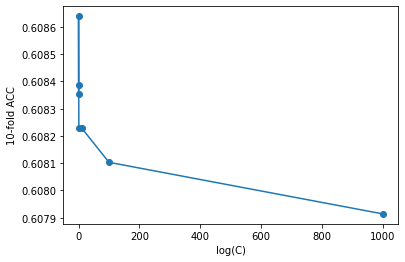

In [12]:
scores = np.array(grid.cv_results_['mean_test_score'])
plt.plot(Crange,scores,'-o')
plt.xlabel('log(C)')
plt.ylabel('10-fold ACC')

plt.show()

We see that a low value of C performs much better than the rest of values tried and as we increase C the accuracy value goes down. Therefore, we will keep the value for C given by the grid.best_params_

### Train with the best parameters

In [8]:
COpt = grid.best_params_['C']
logitModel = LogisticRegression(C =COpt, max_iter = 10000)
logitModel.fit(X_train,y_train)

print("Train: ",logitModel.score(X_train,y_train))
print("Test: ",logitModel.score(X_test,y_test))

Train:  0.6080718902727416
Test:  0.6041114894690377


### Save the model

In [9]:
filename = '../models/Logit.sav'
pickle.dump(logitModel, open(filename, 'wb'))

### Load model

In [10]:
# load the model from disk
filename = '../models/Logit.sav'
logitModel = pickle.load(open(filename, 'rb'))
result = logitModel.score(X_test, y_test)
print(result)

0.6041114894690377


### Evaluate the model


--> The classification report is: 
               precision    recall  f1-score   support

         0.0       0.58      0.52      0.55      3684
         1.0       0.62      0.68      0.65      4245

    accuracy                           0.60      7929
   macro avg       0.60      0.60      0.60      7929
weighted avg       0.60      0.60      0.60      7929



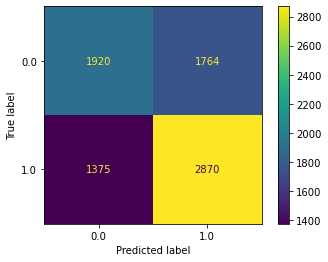

In [11]:
predictionsLogit = logitModel.predict(X_test)
print("\n--> The classification report is: \n", classification_report(y_test, predictionsLogit))
plot_confusion_matrix(logitModel, X_test, y_test)

Recall is again close to 0.7, which is good for our model.

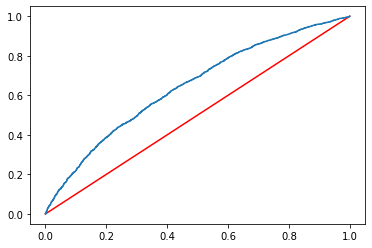

The AUC score is: 0.645525744664797


In [12]:
probsLogit = logitModel.predict_proba(X_test)[:,1]

base_fpr, base_tpr,_ = roc_curve(y_test, [1 for _ in range(len(y_test))])
plt.plot(base_fpr, base_tpr, color = 'r')

fpr,tpr,_ = roc_curve(y_test, probsLogit)
plt.plot(fpr,tpr)

plt.show()
print("The AUC score is:", roc_auc_score(y_test,probsLogit))

The ROC curve is quite close to 0.5 which is not good. However, the 0.14 points of difference in the AUC make the model valuable.